# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
cut = int(num_test / 2)
print (cut)
test_data, test_labels = newsgroups_test.data[cut:], newsgroups_test.target[cut:]
dev_data, dev_labels = newsgroups_test.data[:cut], newsgroups_test.target[:cut]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:' + str(train_labels.shape))
print ('test label shape:' + str(test_labels.shape))
print ('dev label shape:' + str(dev_labels.shape))
print ('labels names:' + str(newsgroups_train.target_names))

676
training label shape:(2034,)
test label shape:(677,)
dev label shape:(676,)
labels names:['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def P1(num_examples=5):
    for i in range(0, num_examples):
        print ('message: ' + str(newsgroups_test.data[i]) + ', label:' + newsgroups_train.target_names[newsgroups_test.target[i]])
    
P1(5)

message: TRry the SKywatch project in  Arizona., label:sci.space
message: The Vatican library recently made a tour of the US.
 Can anyone help me in finding a FTP site where this collection is 
 available., label:comp.graphics
message: Hi there,

I am here looking for some help.

My friend is a interior decor designer. He is from Thailand. He is
trying to find some graphics software on PC. Any suggestion on which
software to buy,where to buy and how much it costs ? He likes the most
sophisticated 
software(the more features it has,the better), label:comp.graphics
message: RFD
                          Request For Discussion
                                for the
                          OPEN  TELEMATIC GROUP

                                  OTG

I have proposed the forming of a consortium/task force for the
promotion of NAPLPS/JPEG, FIF to openly discuss ways, method,
procedures,algorythms, applications, implementation, extensions of
NAPLPS/JPEG standards.  These standards should f

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [5]:
def P2():
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    print ('size of vocabulary: %d' % X.shape[1])
    print ('average number of non-zero feasures per example: %d' % (X.nnz / X.shape[0]))

    feature_names = vectorizer.get_feature_names()
    print ('first feature string: %s, last feature string: %s' % (feature_names[0], feature_names[len(feature_names) - 1]))
    
    vocab = ["atheism", "graphics", "space", "religion"]
    custom_vocab_vectorizer = CountVectorizer(vocabulary=vocab)
    custom_X = custom_vocab_vectorizer.fit_transform(train_data)
    print ('shape of vectorizer with custom vocabulary: %s' % str(custom_X.shape))
    print ('with custom vocabulary, average number of non-zero feasures per example: %f' % (custom_X.nnz / custom_X.shape[0]))
    
    gram_vectorizer = CountVectorizer(ngram_range=(2, 3))
    gram_X = gram_vectorizer.fit_transform(train_data)
    print ('size of vocabulary that includes bi, tri grams: %d' % gram_X.shape[1])
    
    prune_vectorizer = CountVectorizer(min_df=10)
    prune_X = prune_vectorizer.fit_transform(train_data)
    print ('size of vocabulary that prunes words that appear less than 10 documents: %d' % prune_X.shape[1])
    
    dev_X = vectorizer.fit_transform(dev_data)
    dev_feature_names = vectorizer.get_feature_names()
    diff = set(dev_feature_names) - set(feature_names)
    fraction = len(diff) / len(dev_feature_names)
    print ('fraction of words in dev data set missing from training vocabulary: %f' % fraction)
P2()

size of vocabulary: 26879
average number of non-zero feasures per example: 96
first feature string: 00, last feature string: zyxel
shape of vectorizer with custom vocabulary: (2034, 4)
with custom vocabulary, average number of non-zero feasures per example: 0.268437
size of vocabulary that includes bi, tri grams: 510583
size of vocabulary that prunes words that appear less than 10 documents: 3064
fraction of words in dev data set missing from training vocabulary: 0.247876


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [291]:
def P3():    
    train_vectorizer = CountVectorizer()
    train_vectors = train_vectorizer.fit_transform(train_data)
    
    dev_vectors = train_vectorizer.transform(dev_data)

    # grid search for best k ( 1 - 1000 )
    neigh = KNeighborsClassifier()
    ks = {'n_neighbors': [i for i in range(1, 1001)]}
    optimized = GridSearchCV(neigh, ks)
    optimized.fit(train_vectors, train_labels)
    predicted = [optimized.predict(vec)[0] for vec in dev_vectors]
    score = metrics.f1_score(dev_labels, predicted, average='weighted')  
    print ('best k: %s' % str(optimized.best_params_))
    print ('best f score: %f' % score)

    # grid search for best alpha (0.01 - 10)
    mnb = MultinomialNB()
    alphas = {'alpha': [i / 100.0 for i in range(1,1001)]}
    optimized = GridSearchCV(mnb, alphas)
    optimized.fit(train_vectors, train_labels)
    predicted = [optimized.predict(vec)[0] for vec in dev_vectors]
    score = metrics.f1_score(dev_labels, predicted, average='weighted')
    print ('best alpha: %s' % str(optimized.best_params_))
    print ('best f score: %f' % score)
    
    # grid search for best regularization C ( 0.1 - 10 )
    lg = LogisticRegression(penalty='l2')
    cs = {'C': [i / 10.0 for i in range(1,101)]}
    optimized = GridSearchCV(lg, cs)
    optimized.fit(train_vectors, train_labels)
    predicted = [optimized.predict(vec)[0] for vec in dev_vectors]
    score = metrics.f1_score(dev_labels, predicted, average='weighted')
    print ('best C: %s' % str(optimized.best_params_))
    print ('best f score: %f' % score)
    
    all = []
    for c in [i / 10.0 for i in range(1,11)]:
        lg = LogisticRegression(penalty='l2', C=c)
        lg.fit(train_vectors, train_labels)        
        classes = []
        for clas in range(0, 4):
            classes.append(sum([i * i for i in lg.coef_[clas]]))
        all.append(classes)
    
    # print sum of square of weight for each class to inspect relationship
    print ("for class 0, as C increases")
    print ([i[0] for i in all])
    print ("for class 1, as C increases")
    print ([i[1] for i in all])
    print ("for class 2, as C increases")
    print ([i[2] for i in all])
    print ("for class 3, as C increases")
    print ([i[3] for i in all])
P3()

best k: {'n_neighbors': 151}
best f score: 0.422548
best alpha: {'alpha': 0.02}
best f score: 0.783038
best C: {'C': 0.2}
best f score: 0.705873
for class 0, as C increases
[27.124924552702698, 49.749671471401818, 69.277011617941923, 86.724275603781606, 102.59775439791913, 117.23365472229979, 130.86309575747626, 143.65022112608477, 155.53240200475585, 167.01424819921482]
for class 1, as C increases
[24.656217108897685, 42.740645044299747, 57.886979673291158, 71.112622495599609, 83.106578042645168, 94.079665515952598, 104.17771773473417, 113.58451254625169, 122.48959240535295, 130.88335686432308]
for class 2, as C increases
[27.45955069632252, 49.324258856192039, 67.907162023179893, 84.261738183821549, 99.017273556296246, 112.52611041318963, 125.01795565056509, 136.6603318562837, 147.62871444533437, 158.00270089045699]
for class 3, as C increases
[23.023944329479843, 42.668003519715604, 59.777359139961213, 75.067567640446697, 89.007207824416199, 101.84334895956384, 113.84223784121798, 1

ANSWER:

a. the word frequency matrix over the entire vocabulary is too sparse for KNN to be effective ( even if two documents belong to same category, their word occurance vector may be still too far apart )
b. in this exmaple, there are not enough training data for logistic regression to outperform naive bayes ( the number of features is greater than the number of training examples ). In general, with enough training examples, logistic regression should always out perform bayes because of bayes's assumption of conditional independence. But bayes converges to a good predictive model much faster than logistic regression
c. As C goes up, the sum also goes up

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

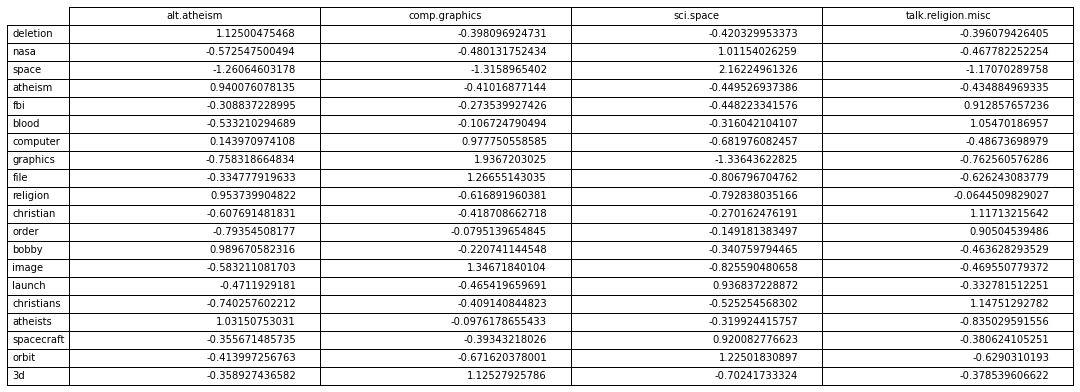

In [5]:
# draw a table of top 5 weighted features for each class for passed in logistic regression model
def table_weights(lg, feature_names):
    # collect top 5 weighted feature for each label into label_weights
    label_weights = {}
    label_weights[0] = {}
    label_weights[1] = {}
    label_weights[2] = {}
    label_weights[3] = {}
    for clas in range(0, 4):
        l = lg.coef_[clas]
        sl = sorted(l)[-5:]
        for w in sl:
            idx = np.where(l==w)
            idx = idx[0][0]
            feature = feature_names[idx]
            label_weights[0][feature] = lg.coef_[0][idx]
            label_weights[1][feature] = lg.coef_[1][idx]
            label_weights[2][feature] = lg.coef_[2][idx]
            label_weights[3][feature] = lg.coef_[3][idx]

    # transform label_weights into table friendly array
    col_labels=['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    row_labels = []
    for f in label_weights[0]:
        row_labels.append(f)
    
    table_vals=[]
    for f in row_labels:
        row = [label_weights[0][f],label_weights[1][f],label_weights[2][f],label_weights[3][f]]
        table_vals.append(row)

    ax = plt.subplot(111, frame_on=False) 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 

    # show table
    the_table = plt.table(cellText=table_vals,
                      colWidths = [0.5]*30,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
    the_table.scale(1.5,1.5)

def P4():
    lg = LogisticRegression(penalty='l2')

    # train a logistic regression model with unigram
    train_vectorizer = CountVectorizer()
    train_vectors = train_vectorizer.fit_transform(train_data)
    feature_names = train_vectorizer.get_feature_names()
    lg.fit(train_vectors, train_labels)
        
    table_weights(lg, feature_names)
P4()

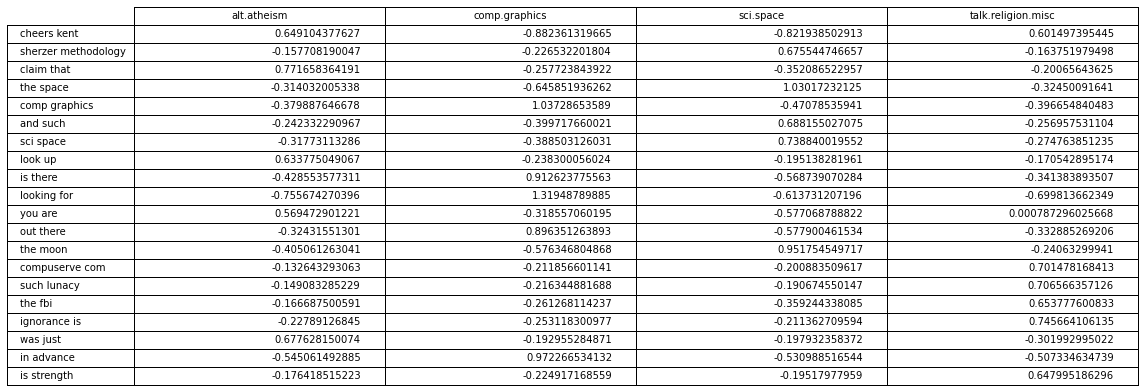

In [5]:
# P4 continued
def P4():
    lg = LogisticRegression(penalty='l2')
    
    # train a logistic regression model with bigram
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
    bigram_vectors = bigram_vectorizer.fit_transform(train_data)
    feature_names = bigram_vectorizer.get_feature_names()
    lg.fit(bigram_vectors, train_labels)
    
    # draw table
    table_weights(lg, feature_names)

P4()

ANSWER: some word that is significant in unigram model is also significant in the bigram model i.e. space ( the space ), moon ( the moon ), fbi ( the fbi )

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [364]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):    
    # make all lower cases
    s = s.lower()

    # get rid of some plurals and third person verb
    s = re.sub(r'(es )', 'e ', s)
    
    # remove non alphabet/digit character
    s = re.sub(r'([^0-9a-zA-Z ])', ' ', s)
    
    # replace sequence of numbers with '!@#$%^&*' token
    s = re.sub(r'( \d+ )', ' !@#$%^&* ', s)
    
    return s

def P5():
    # train a logistic regression without preprocessing
    train_vectorizer = CountVectorizer(preprocessor=empty_preprocessor)
    train_vectors = train_vectorizer.fit_transform(train_data)
    dev_vectors = train_vectorizer.transform(dev_data)
    lg = LogisticRegression(penalty='l2', C=0.2)
    lg.fit(train_vectors, train_labels)
    predicted = [lg.predict(vec)[0] for vec in dev_vectors]
    score = metrics.f1_score(dev_labels, predicted, average='weighted')
    print ('before preprocessing, vocab size is:', train_vectors.shape[1])
    print ('before preprocessing, f score is: %f' % score)
    
    # train a logistic regression with preprocessing
    train_vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    train_vectors = train_vectorizer.fit_transform(train_data)
    dev_vectors = train_vectorizer.transform(dev_data)
    lg = LogisticRegression(penalty='l2', C=0.2)
    lg.fit(train_vectors, train_labels)
    predicted = [lg.predict(vec)[0] for vec in dev_vectors]
    score = metrics.f1_score(dev_labels, predicted, average='weighted')
    print ('after preprocessing, vocab size downed to:', train_vectors.shape[1])
    print ('after preprocessing, improved f score: %f' % score)

P5()

before preprocessing, vocab size is: 33291
before preprocessing, f score is: 0.702608
after preprocessing, vocab size downed to: 25442
after preprocessing, improved f score: 0.722177


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

number of non-zero weight features with l2 penalty: 107516
number of non-zero weight features with l1 penalty: 1636


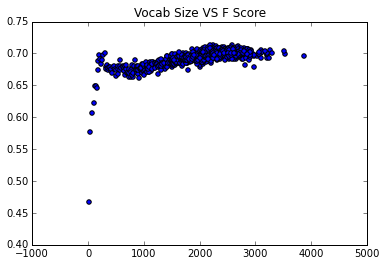

In [3]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    train_vectorizer = CountVectorizer()
    train_vectors = train_vectorizer.fit_transform(train_data)
    dev_vectors = train_vectorizer.transform(dev_data)
    
    # train logistic regression with l2 penalty
    lg = LogisticRegression(penalty='l2')
    lg.fit(train_vectors, train_labels)
    print('number of non-zero weight features with l2 penalty: %d' % len(lg.coef_.nonzero()[1]))

    # train logistic regression with l1 penalty
    lg = LogisticRegression(penalty='l1')
    lg.fit(train_vectors, train_labels)
    print('number of non-zero weight features with l1 penalty: %d' % len(lg.coef_.nonzero()[1]))

    vocab_size = []
    f_score = []
    # retrain with non zero weight features and various regularization strengths
    #for c in range(1, 101):
    for c in [i / 100.0 for i in range(1,1001)]:
        lg = LogisticRegression(penalty='l1', tol=0.01, C=c)
        lg.fit(train_vectors, train_labels)
        
        pruned_train_vectors = train_vectors[:, np.unique(lg.coef_.nonzero()[1])]
        pruned_dev_vectors = dev_vectors[:, np.unique(lg.coef_.nonzero()[1])]

        lg = LogisticRegression(penalty='l2')
        lg.fit(pruned_train_vectors, train_labels)
        predicted = [lg.predict(vec)[0] for vec in pruned_dev_vectors]
        score = metrics.f1_score(dev_labels, predicted, average='weighted')
        f_score.append(score)
        vocab_size.append(pruned_train_vectors.shape[1])
        #print ('for c=%f, pruned vocab size, %d, f score with retrained l2 model: %f' % (c, pruned_train_vectors.shape[1], score))

    plt.title("Vocab Size VS F Score")
    plt.scatter(vocab_size, f_score)
    plt.show()
P6()

#### (7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [12]:
def P7():
    train_vectorizer = TfidfVectorizer()
    train_vectors = train_vectorizer.fit_transform(train_data)
    dev_vectors = train_vectorizer.transform(dev_data)
    feature_names = train_vectorizer.get_feature_names()

    lg = LogisticRegression(C=100)
    lg.fit(train_vectors, train_labels)
    
    predicted = [lg.predict(vec)[0] for vec in dev_vectors]
    score = metrics.f1_score(dev_labels, predicted, average='weighted')
    print ('f score is %f', score)
    
    prob = lg.predict_proba(dev_vectors)
    rs = []
    r2Doc = {}
    sample = 3
    for i in range(0, dev_vectors.shape[0]):
        r = max(prob[i]) / prob[i][dev_labels[i]]
        rs.append(r)
        ps = prob[i]
        mp = max(ps)
        r2Doc[r] = {'doc': dev_data[i], 'predicted': np.where(ps==mp)[0][0], 'true': dev_labels[i]}
    rs = sorted(rs, reverse=True)[:sample]
    for i in range(0, sample):
        print ('r=%f' % rs[i])
        print ('predicted=%s' % newsgroups_train.target_names[r2Doc[rs[i]]['predicted']])
        print ('actual=%s' % newsgroups_train.target_names[r2Doc[rs[i]]['true']])
        print ('doc=%s' % r2Doc[rs[i]]['doc'])

P7()

f score is %f 0.759766242785
r=929.343050
predicted=comp.graphics
actual=talk.religion.misc
doc=I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the 

ANSWER: instead of using word frequence as feature value, TfidfVectorizer uses Term Frequency times Inverse Document Frequency as feature values, so that it makes words that appear frequently in many documents have less impact

a couple issues noticed for this model

1) a lot of computer related jargons appear to cause the model to incorrectly classify document to be computer graphics ( like the top 2 documents )
2) religion and atheism are easily confused

ideas to address these issues

1) remove computer jargon words
2) use multi-gram instead of unigram
3) emphasize the words in the first three sentences ( assuming that the first three sentences are more indicative about the topic of the document ) by duplicating it in the document

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [23]:
def better_preprocessor(s):    
    # make all lower cases
    s = s.lower()

    # duplicate first three sentence
    first = '.'.join(s.split(".")[:3]) + '.'
    s = first + s

    # get rid of some plurals and third person verb
    s = re.sub(r'(es )', 'e ', s)
    
    # remove non alphabet/digit character
    s = re.sub(r'([^0-9a-zA-Z ])', ' ', s)
    
    # replace sequence of numbers with '!@#$%^&*' token
    s = re.sub(r'( \d+ )', ' !@#$%^&* ', s)
    
    # remove computer jargons
    s = re.sub(r'(computer)', '', s)
    s = re.sub(r'(internet)', '', s)
    s = re.sub(r'(ftp)', '', s)
    s = re.sub(r'(postscript)', '', s)
    s = re.sub(r'(rtf)', '', s)
    s = re.sub(r'(ascii)', '', s)
    s = re.sub(r'(latex)', '', s)
    s = re.sub(r'(processors)', '', s)
    s = re.sub(r'(printers)', '', s)
    s = re.sub(r'(microsoft)', '', s)

    return s

def P8():
    train_vectorizer = TfidfVectorizer(ngram_range=(1, 1), preprocessor=better_preprocessor)
    train_vectors = train_vectorizer.fit_transform(train_data)
    dev_vectors = train_vectorizer.transform(dev_data)
    feature_names = train_vectorizer.get_feature_names()

    lg = LogisticRegression(C=100)
    lg.fit(train_vectors, train_labels)
    
    predicted = [lg.predict(vec)[0] for vec in dev_vectors]
    score = metrics.f1_score(dev_labels, predicted, average='weighted')
    print ('f score is %f', score)
    print ('top three r values:')
    prob = lg.predict_proba(dev_vectors)
    rs = []
    r2Doc = {}
    sample = 3
    for i in range(0, dev_vectors.shape[0]):
        r = max(prob[i]) / prob[i][dev_labels[i]]
        rs.append(r)
        ps = prob[i]
        mp = max(ps)
        r2Doc[r] = {'doc': dev_data[i], 'predicted': np.where(ps==mp)[0][0], 'true': dev_labels[i]}
    rs = sorted(rs, reverse=True)[:sample]
    for i in range(0, sample):
        print ('r=%f' % rs[i])

P8()

f score is %f 0.761441580572
r=300.122370
r=275.657696
r=257.868838
